In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
words = open('../names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
char2idx = {s:i+1 for i,s in enumerate(chars)}
char2idx['.'] = 0
idx2char = {i:s for s,i in char2idx.items()}
print(idx2char)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
def build_dataset(words): 
    X = []
    Y = []
    
    for w in words:
        chrs = (block_size) * ['.'] + list(w)
        for i in range(len(chrs) - block_size + 1):
            X.append([char2idx[c] for c in chrs[i: i + block_size]])
            idx = char2idx[chrs[i + block_size]] if i + block_size < len(chrs) else char2idx['.']
            Y.append(idx)
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.shuffle(words)
# split the data to 80% training, 10% validation, 10% testing
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182550, 3]) torch.Size([182550])
torch.Size([22764, 3]) torch.Size([22764])
torch.Size([22832, 3]) torch.Size([22832])


In [8]:
block_size = 3
hidden_layer = 200
embedding_dim = 10

In [7]:
C = torch.randn(27, embedding_dim)
W1 = torch.randn(embedding_dim * block_size, hidden_layer) # embedding_dim * block_size is the number of parameter for each example
b1 = torch.randn(hidden_layer)
W2 = torch.randn(hidden_layer, len(char2idx)) # output propabily for each char
b2 = torch.randn(len(char2idx))
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

11897

In [8]:
# Adding lr decay and train only on Xtr
lossi = []
stepi = []
max_steps = 10_000
for p in parameters:
    p.requires_grad = True

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # batch size of 32
    # forward pass
    emd = C[Xtr[ix]] 
    h = F.tanh(emd.view(-1, embedding_dim * block_size) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parametrs
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    if i % 1_000 == 0:
        print(f'{i:7d} / {max_steps: 7d}: {loss.item():.4f}')
        
    lossi.append(loss.log10().item())
    stepi.append(i)
    break
    

      0 /   10000: 25.5435


In [9]:
logits[0] # it takes quite extreme values

tensor([  0.6314,  -3.4343,  -8.8950,  -7.7950,   4.6205,  -4.4228,  -6.4873,
          7.9102, -13.5315, -14.4420, -18.0178,  -3.8268, -12.2488,  -6.8547,
        -14.5363,  -5.9709,   6.0426,   5.1153,   0.8044,  -1.9475,   6.9070,
          8.4608,   5.3690,  10.2532,   7.0244,   6.4073,   2.2439],
       grad_fn=<SelectBackward0>)

In [10]:
# The high loss in initialization (22.4892 ) stems from the facts the net has high confidence in the worng values
# We would have expected that the prob will be 1/27 (uniform destrebution)
-torch.tensor(1/27.0).log() # negative log liklihood

tensor(3.2958)

In [12]:
# 4-dim example of the issue
logits = torch.tensor([0.0, 0.0, 10.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([4.5394e-05, 4.5394e-05, 9.9986e-01, 4.5394e-05]), tensor(0.0001))

In [14]:
logits = torch.tensor([10.0, -1.0, 0.0, 5.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([9.9325e-01, 1.6589e-05, 4.5093e-05, 6.6924e-03]), tensor(10.0068))

In [7]:
# logits = h @ W2 + b2
# We want the logits to be small, so lets change the initalzation of W2 and b2
C = torch.randn(27, embedding_dim)
W1 = torch.randn(embedding_dim * block_size, hidden_layer) # embedding_dim * block_size is the number of parameter for each example
b1 = torch.randn(hidden_layer)
W2 = torch.randn(hidden_layer, len(char2idx)) * 0.01
b2 = torch.randn(len(char2idx)) * 0
parameters = [C, W1, b1, W2, b2]

In [8]:
# Adding lr decay and train only on Xtr
lossi = []
stepi = []
max_steps = 10_000
for p in parameters:
    p.requires_grad = True

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # batch size of 32
    # forward pass
    emd = C[Xtr[ix]] 
    hpreact = emd.view(-1, embedding_dim * block_size) @ W1 + b1
    h = F.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parametrs
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    if i % 1_000 == 0:
        print(f'{i:7d} / {max_steps: 7d}: {loss.item():.4f}')
        
    lossi.append(loss.log10().item())
    stepi.append(i)
    break

      0 /   10000: 3.3119


In [9]:
h # h has numerous values equal to 1 or -1

tensor([[ 0.8160,  1.0000, -0.5175,  ...,  0.9980,  0.9767, -0.0365],
        [-1.0000,  1.0000, -0.8818,  ..., -0.9952, -1.0000,  0.9999],
        [ 1.0000,  1.0000, -0.4149,  ..., -0.7933,  1.0000,  1.0000],
        ...,
        [ 0.0092,  0.9984, -1.0000,  ..., -0.9498,  0.9506,  0.6687],
        [ 0.9992,  1.0000, -0.7082,  ..., -0.9983,  1.0000, -0.9999],
        [ 1.0000,  0.9866,  0.9999,  ...,  1.0000, -1.0000, -1.0000]],
       grad_fn=<TanhBackward0>)

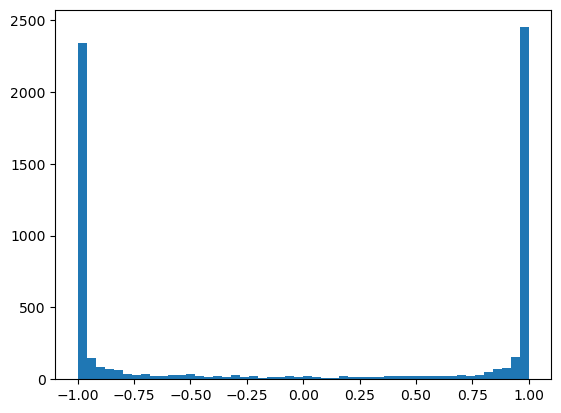

In [10]:
plt.hist(h.view(-1).tolist(), 50);

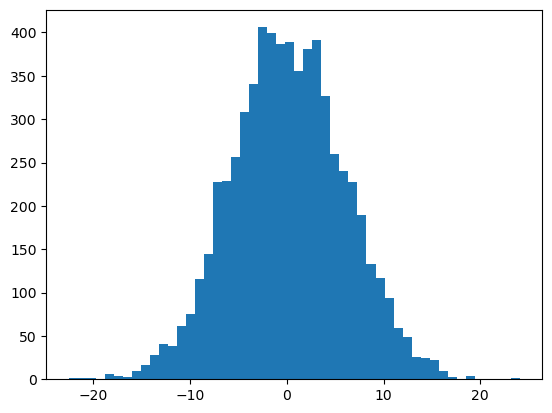

In [11]:
plt.hist(hpreact.view(-1).tolist(), 50); 

In [ ]:
# The backward of tanh (1 - t**2) * out.grad only ever decreases
# So, if t = 1 or -1, we're nullifying the gradient 


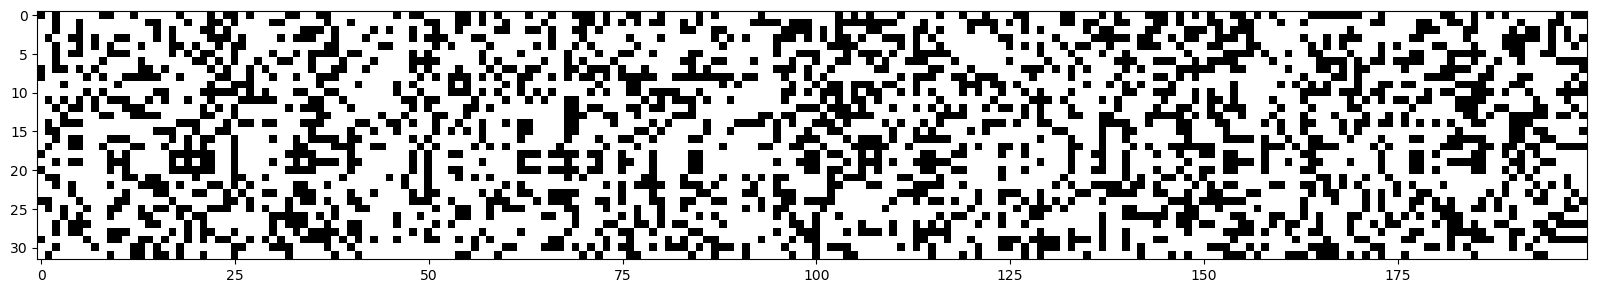

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# In all the blank spaces, the gradient will be destroyed
# If an entire column is white, we would have a dead neuron, meaning it would never learn
# True also for sigmoid, RelU etc..

In [18]:
# To fix it we use Kaiming init - tanh gain= 5/3, fanin = n_embd * block_size
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
vocab_size = 27
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
parameters = [C, W1, b1, W2, b2]

In [19]:

lossi = []
stepi = []
max_steps = 10_000
for p in parameters:
    p.requires_grad = True

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # batch size of 32
    # forward pass
    emb = C[Xtr[ix]]
    embact = emb.view(emb.shape[0], -1)
    hpreact = embact @ W1 + b1
    h = F.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parametrs
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    if i % 1_000 == 0:
        print(f'{i:7d} / {max_steps: 7d}: {loss.item():.4f}')
        
    lossi.append(loss.log10().item())
    stepi.append(i)
    break

      0 /   10000: 3.3064


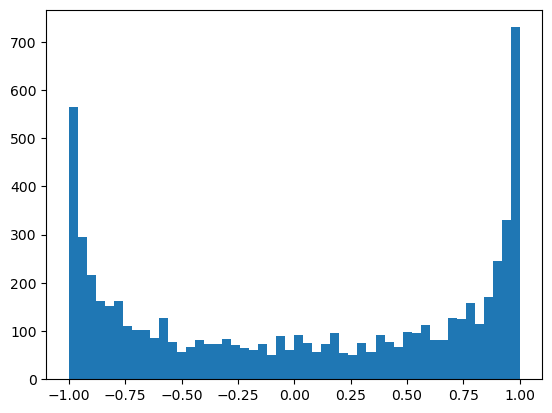

In [20]:
plt.hist(h.view(-1).tolist(), 50);

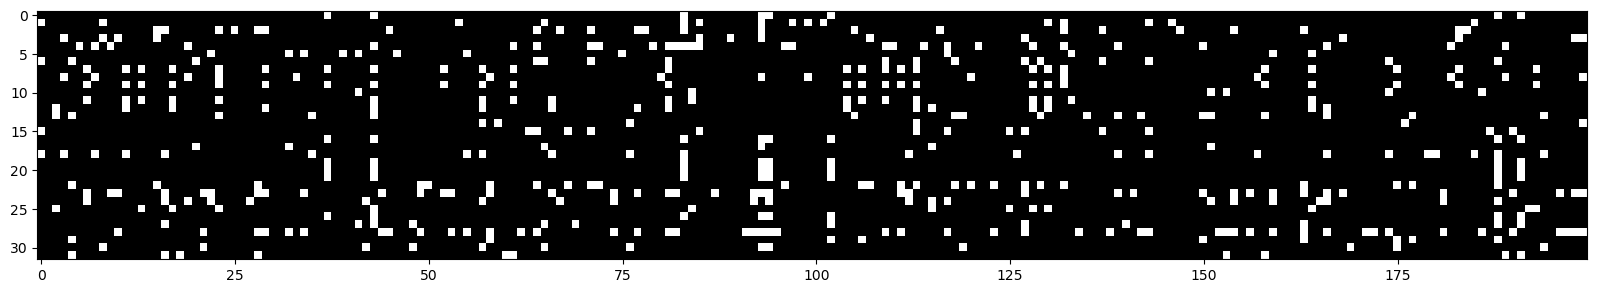

In [21]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [22]:
# Modern innovations enhance stability in neural networks.
# Initialization precision is less critical.
# Innovations include residual connections, normalization layers (batch, layer, group), and advanced optimizers (e.g., RMSprop, Adam).
# These advancements reduce the need for precise neural net initialization.
# that allows us to basically forward individual examples at test time.

In [ ]:
# We are using batch normalization to control the statistics of activations in the neural net
# The batch normalization internally has parameters for the gain and the bias and these are trained using back propagation 
# It also has two buffers the buffers are the mean and the standard deviation the running mean and the running mean of the standard deviation
# The running mean and standard deviation and this will later be used at inference


In [23]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # b1 will be subtracted later, making it redundant.
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [24]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation # b1 will be subtracted later, making it redundant
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3051
  10000/ 200000: 2.0647
  20000/ 200000: 2.4173
  30000/ 200000: 2.1349
  40000/ 200000: 2.4080
  50000/ 200000: 2.1937
  60000/ 200000: 2.2643
  70000/ 200000: 2.0048
  80000/ 200000: 1.7453
  90000/ 200000: 2.2069
 100000/ 200000: 2.4235
 110000/ 200000: 1.9659
 120000/ 200000: 2.2259
 130000/ 200000: 2.1705
 140000/ 200000: 1.8563
 150000/ 200000: 1.8358
 160000/ 200000: 2.2629
 170000/ 200000: 2.0656
 180000/ 200000: 2.3953
 190000/ 200000: 1.6545


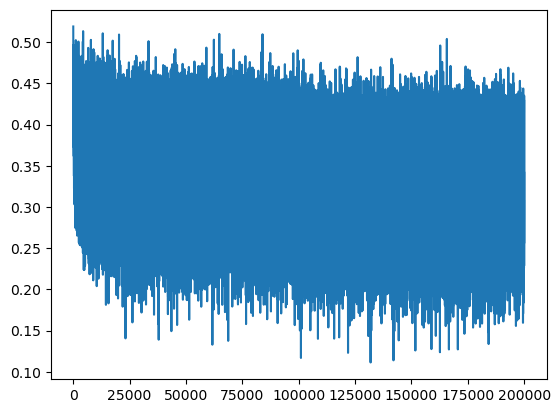

In [26]:
plt.plot(lossi)

In [28]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066314458847046
val 2.120515823364258


In [12]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g)  / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident 
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [77]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3080


layer 1 (      Tanh): mean -0.04, std 0.77, saturated: 23.91%
layer 3 (      Tanh): mean -0.03, std 0.72, saturated: 12.78%
layer 5 (      Tanh): mean +0.01, std 0.74, saturated: 12.12%
layer 7 (      Tanh): mean -0.03, std 0.73, saturated: 12.31%
layer 9 (      Tanh): mean -0.00, std 0.71, saturated: 10.19%


Text(0.5, 1.0, 'activation distribution')

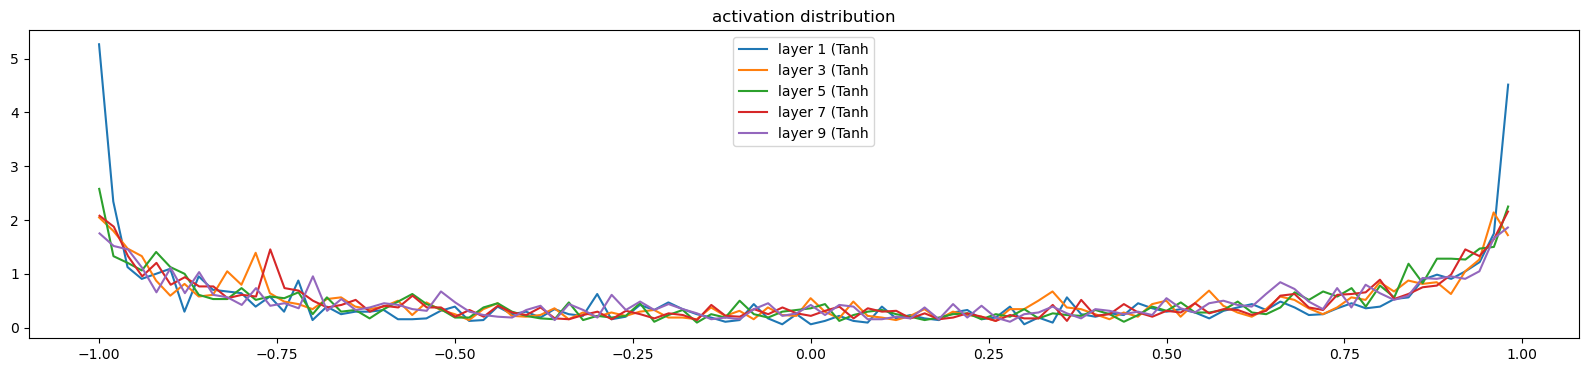

In [64]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer (softmax)
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.04, std 0.65, saturated: 5.22%
layer 3 (      Tanh): mean -0.01, std 0.55, saturated: 0.22%
layer 5 (      Tanh): mean +0.03, std 0.53, saturated: 0.25%
layer 7 (      Tanh): mean -0.00, std 0.52, saturated: 0.25%
layer 9 (      Tanh): mean -0.00, std 0.53, saturated: 0.09%


Text(0.5, 1.0, 'activation distribution')

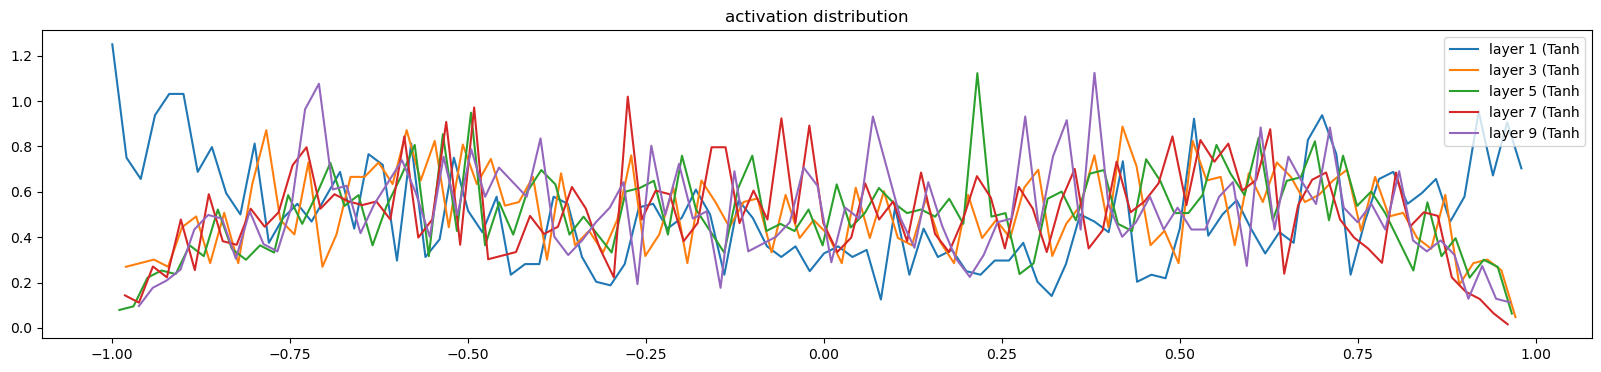

In [39]:
# If we dont use a gain of 5/3
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer (softmax)
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [78]:
# Demonstrates the necessity of some gain to facilitate expansion and counteract the squeezing effect of tanh


layer 1 (      Tanh): mean +0.000025, std 2.932165e-03
layer 3 (      Tanh): mean +0.000039, std 2.670491e-03
layer 5 (      Tanh): mean -0.000025, std 2.560312e-03
layer 7 (      Tanh): mean -0.000055, std 2.604197e-03
layer 9 (      Tanh): mean -0.000020, std 2.375095e-03


Text(0.5, 1.0, 'gradient distribution')

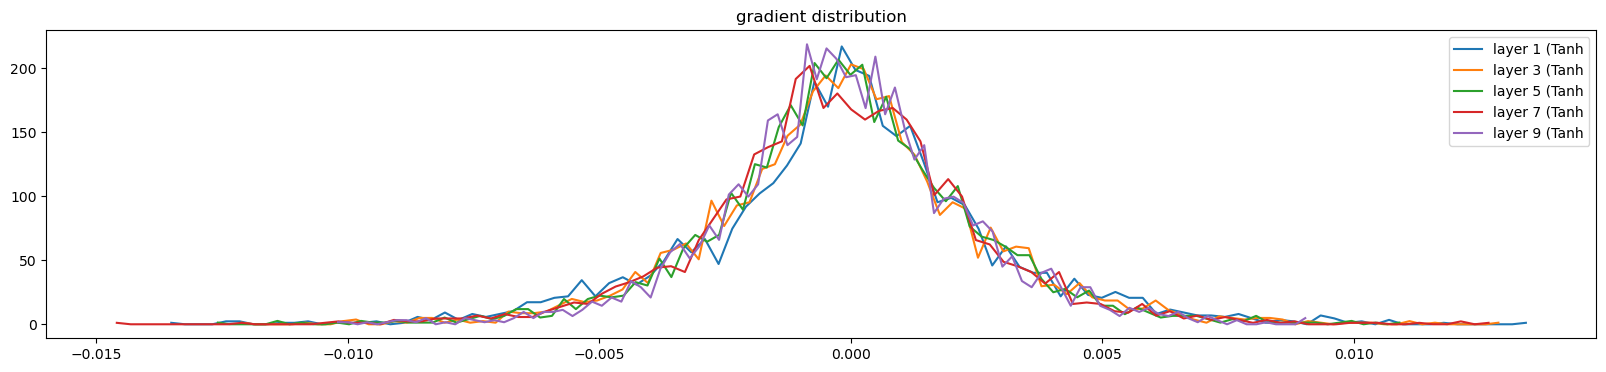

In [41]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

layer 1 (      Tanh): mean +0.000019, std 3.030765e-02
layer 3 (      Tanh): mean +0.000658, std 1.528991e-02
layer 5 (      Tanh): mean +0.000053, std 7.298449e-03
layer 7 (      Tanh): mean +0.000079, std 3.390879e-03
layer 9 (      Tanh): mean -0.000055, std 1.720401e-03


Text(0.5, 1.0, 'gradient distribution')

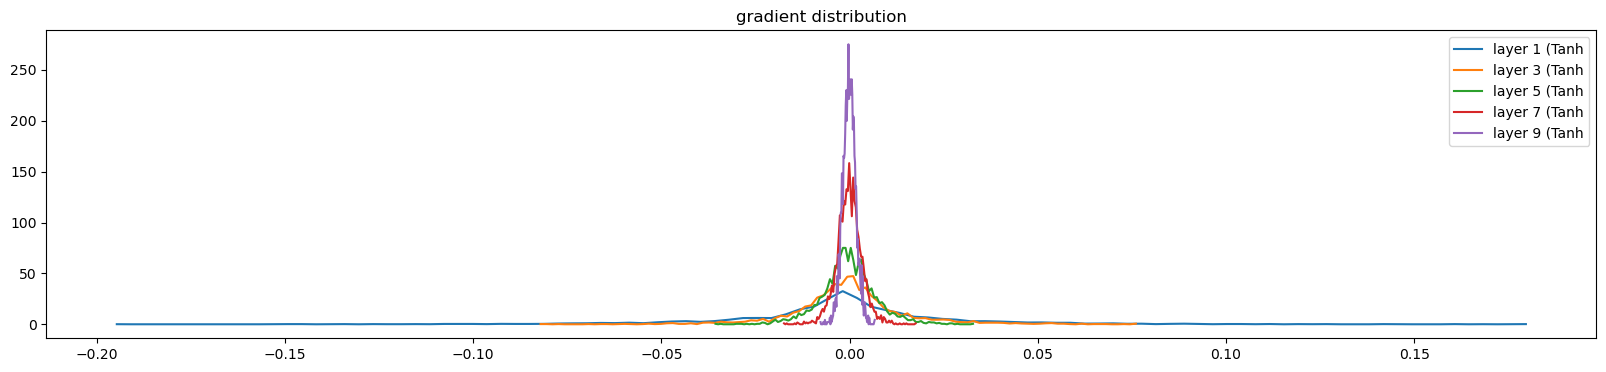

In [51]:
# Without the appropriate gain, encountering vanishing gradient issues
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

layer 1 (      Tanh): mean -0.000000, std 8.378694e-09
layer 3 (      Tanh): mean -0.000000, std 1.767033e-07
layer 5 (      Tanh): mean -0.000000, std 3.536952e-06
layer 7 (      Tanh): mean -0.000002, std 5.948429e-05
layer 9 (      Tanh): mean +0.000021, std 5.971567e-04


Text(0.5, 1.0, 'gradient distribution')

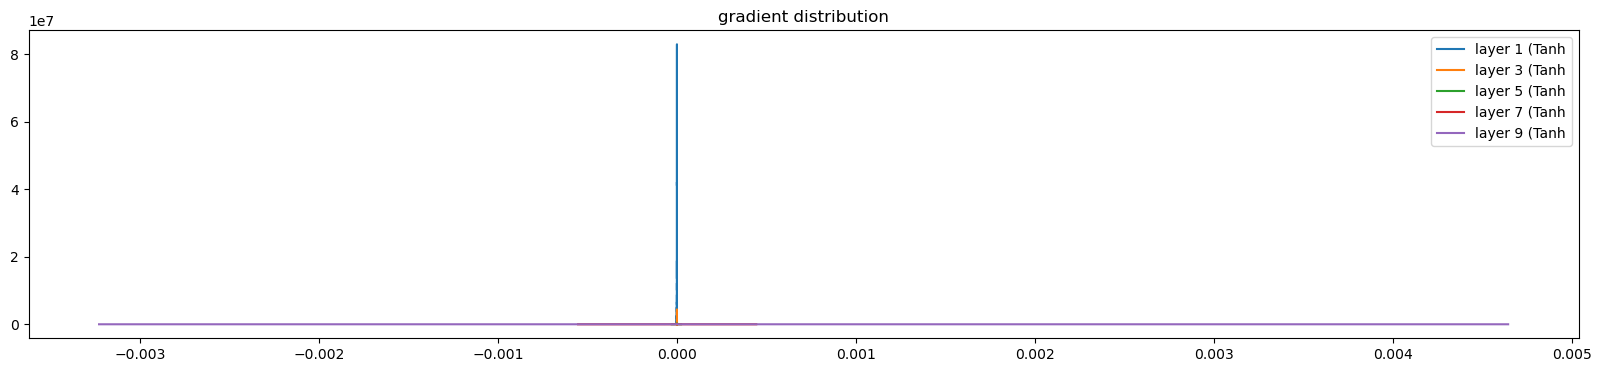

In [61]:
# without the appropirate gain - vanishing gradient 
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000671 | std 1.343037e-02 | grad:data ratio 1.342166e-02
weight  (30, 100) | mean +0.000048 | std 1.027112e-02 | grad:data ratio 3.282139e-02
weight (100, 100) | mean -0.000131 | std 8.211195e-03 | grad:data ratio 4.884071e-02
weight (100, 100) | mean -0.000032 | std 6.979692e-03 | grad:data ratio 4.115193e-02
weight (100, 100) | mean -0.000062 | std 6.606701e-03 | grad:data ratio 3.916393e-02
weight (100, 100) | mean -0.000044 | std 5.700905e-03 | grad:data ratio 3.389936e-02
weight  (100, 27) | mean +0.000000 | std 2.462466e-02 | grad:data ratio 3.592867e-01


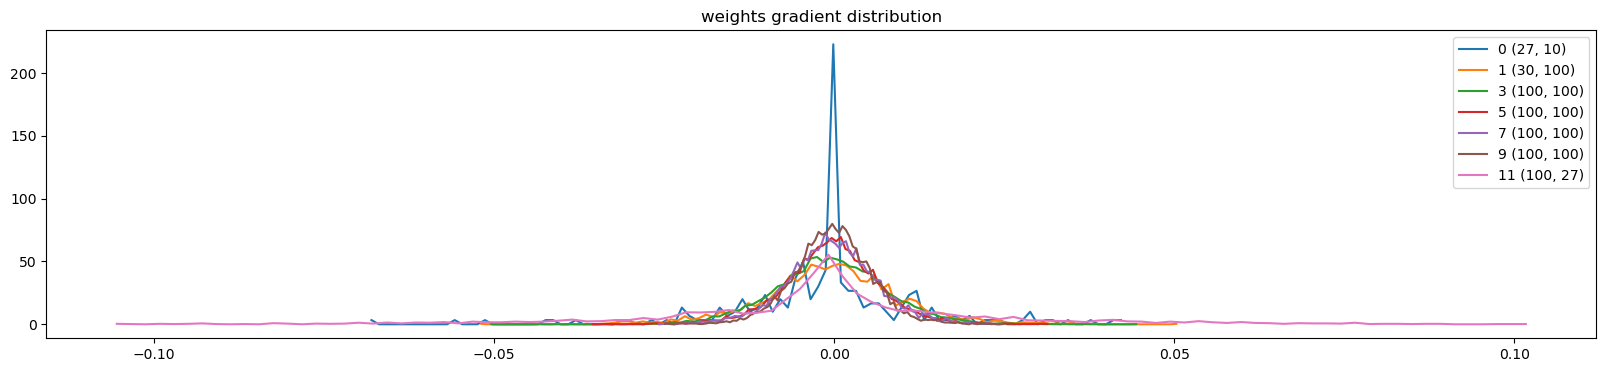

In [65]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

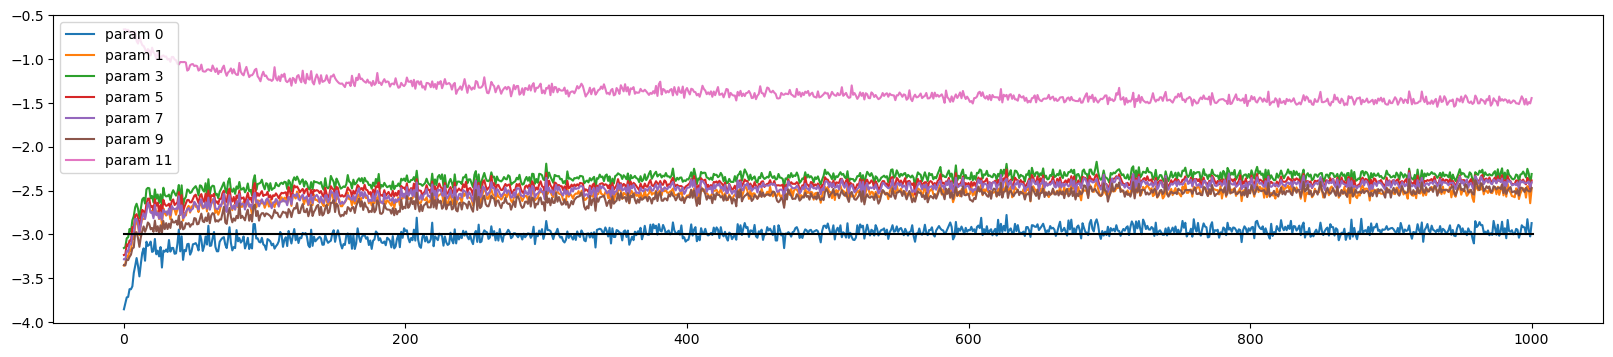

In [66]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: # Only wieghts
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

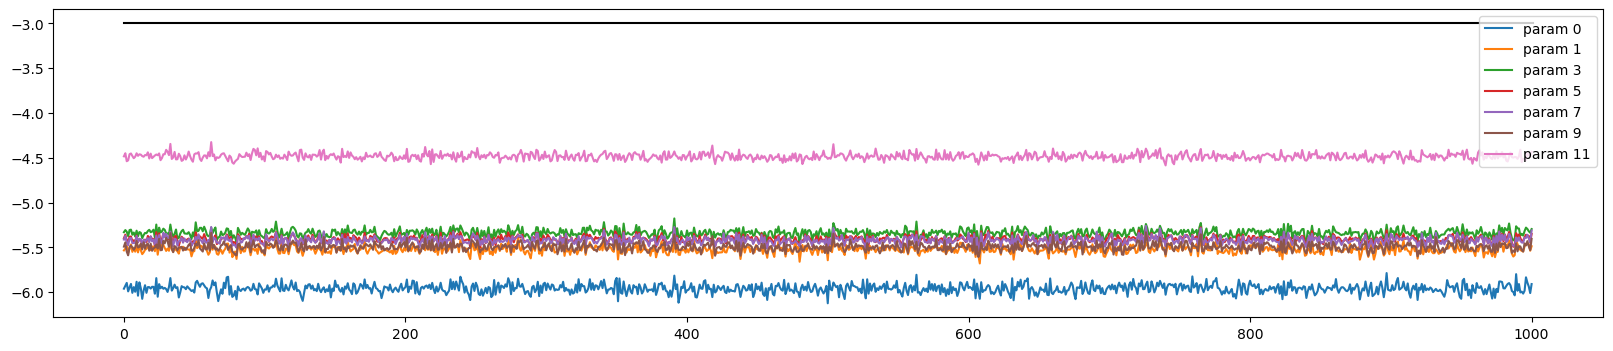

In [68]:
# Demonstrates the logical updating data ratio
# If it were -1, for example, it would excessively update values
# Artificially shrunk down the last layer to maintain softmax uncertainty - layers[-1].weight *= 0.1
# If below -3, it indicates parameters are not learning fast enough (lower learning rate)

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: # Only wieghts
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

layer 1 (      Tanh): mean -0.04, std 0.99, saturated: 97.00%
layer 3 (      Tanh): mean -0.03, std 0.98, saturated: 90.72%
layer 5 (      Tanh): mean -0.02, std 0.98, saturated: 90.00%
layer 7 (      Tanh): mean -0.02, std 0.98, saturated: 91.31%
layer 9 (      Tanh): mean +0.00, std 0.98, saturated: 90.50%


Text(0.5, 1.0, 'activation distribution')

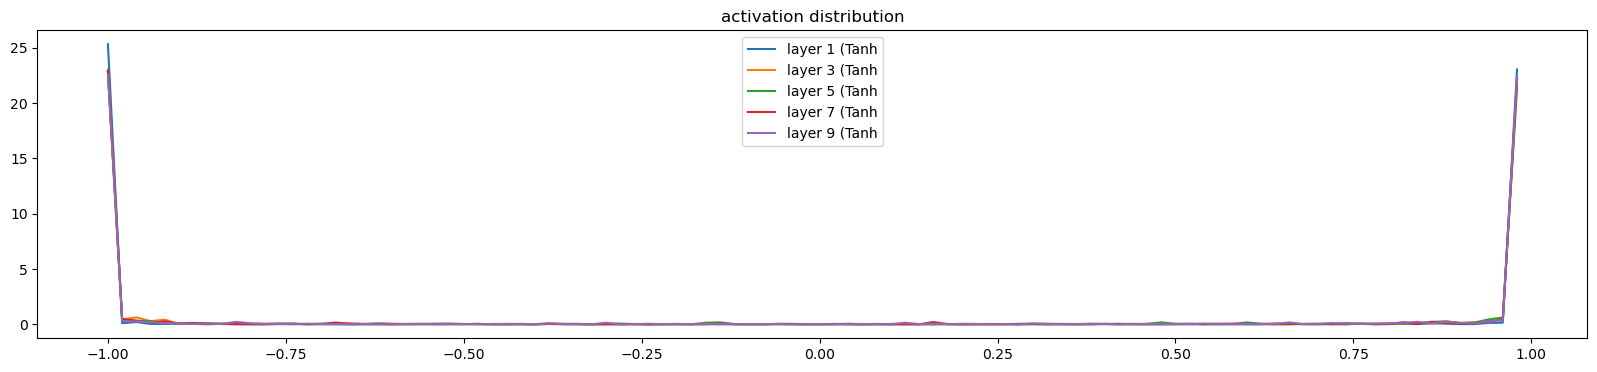

In [72]:
# How to notice if something is off
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer (softmax)
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.004190, std 1.421596e-01
layer 3 (      Tanh): mean +0.000571, std 3.719657e-02
layer 5 (      Tanh): mean +0.000041, std 1.375402e-02
layer 7 (      Tanh): mean +0.000190, std 4.410645e-03
layer 9 (      Tanh): mean -0.000060, std 1.740790e-03


Text(0.5, 1.0, 'gradient distribution')

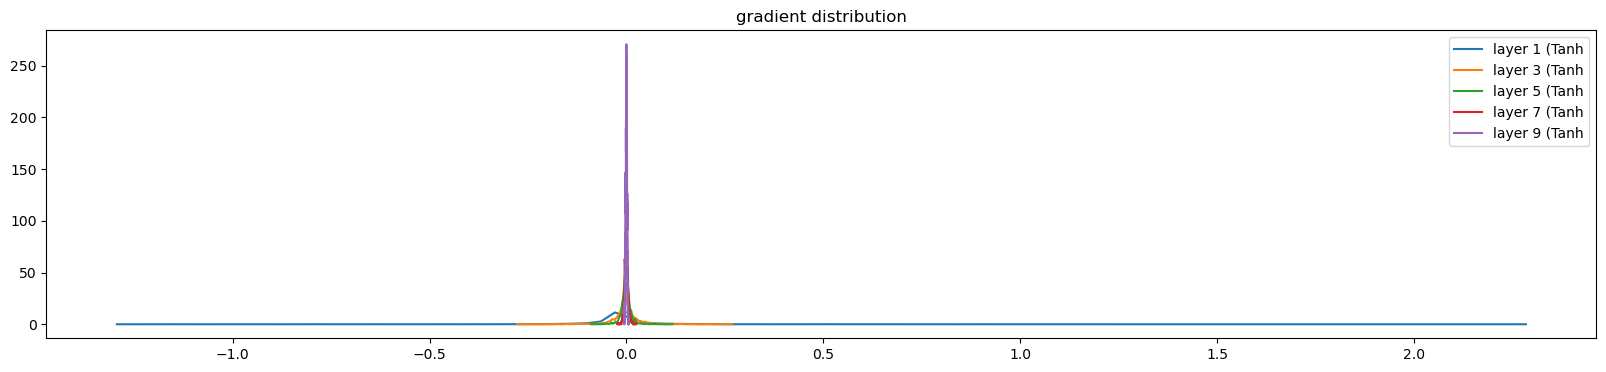

In [73]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.079131 | std 5.231565e-01 | grad:data ratio 2.140973e-01
weight  (30, 100) | mean +0.002351 | std 2.764018e-01 | grad:data ratio 1.438575e-01
weight (100, 100) | mean -0.000013 | std 4.426255e-02 | grad:data ratio 2.650572e-02
weight (100, 100) | mean +0.000135 | std 1.160276e-02 | grad:data ratio 6.907219e-03
weight (100, 100) | mean +0.000039 | std 4.118111e-03 | grad:data ratio 2.463105e-03
weight (100, 100) | mean +0.000000 | std 1.532916e-03 | grad:data ratio 9.160530e-04
weight  (100, 27) | mean -0.000000 | std 3.659768e-02 | grad:data ratio 6.005812e-01


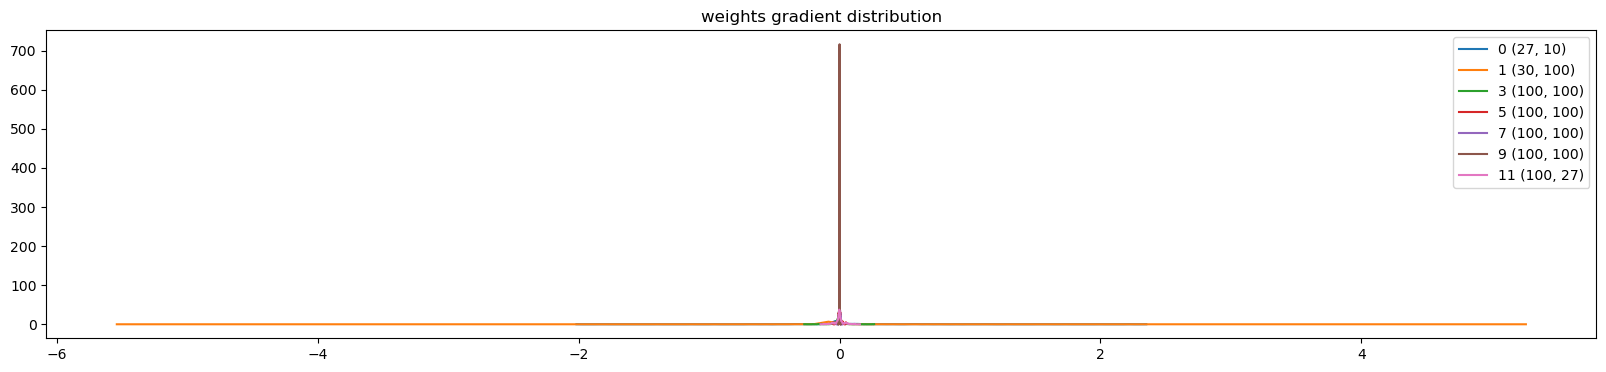

In [74]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

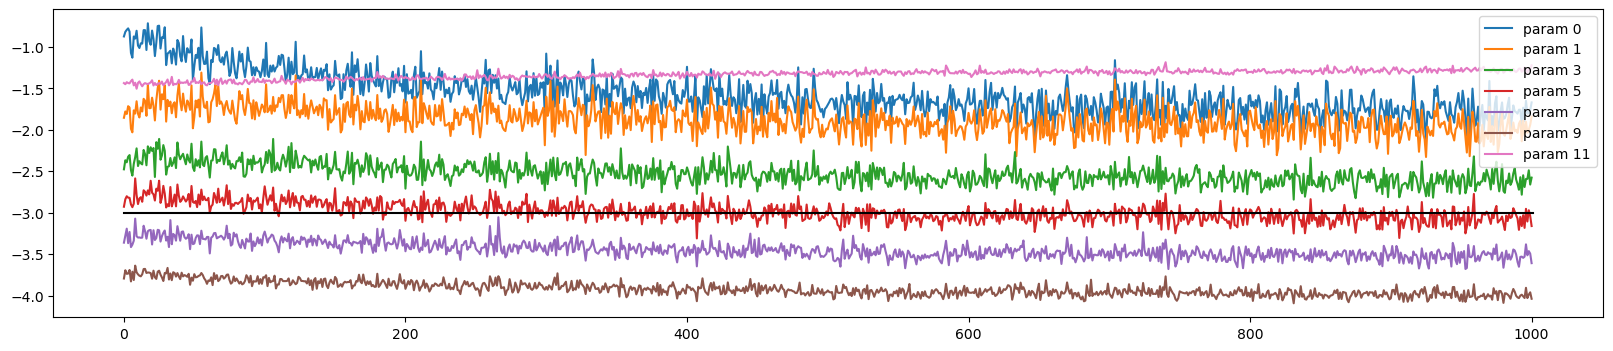

In [75]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: # Only wieghts
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [19]:
# Introducing batch normalization to enhance model performance
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
vocab_size = 27
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [25]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 120_000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.5036
  10000/ 200000: 2.1489
  20000/ 200000: 2.1669
  30000/ 200000: 2.0579
  40000/ 200000: 2.5136
  50000/ 200000: 2.2719
  60000/ 200000: 1.9016
  70000/ 200000: 1.9135
  80000/ 200000: 2.1301
  90000/ 200000: 2.3633
 100000/ 200000: 1.9374
 110000/ 200000: 1.9344
 120000/ 200000: 1.7543
 130000/ 200000: 2.1157
 140000/ 200000: 2.3513
 150000/ 200000: 2.1135
 160000/ 200000: 2.2294
 170000/ 200000: 2.1685
 180000/ 200000: 2.1355
 190000/ 200000: 1.8712


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 2.75%
layer 5 (      Tanh): mean -0.00, std 0.65, saturated: 2.28%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.59%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.03%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 2.00%


Text(0.5, 1.0, 'activation distribution')

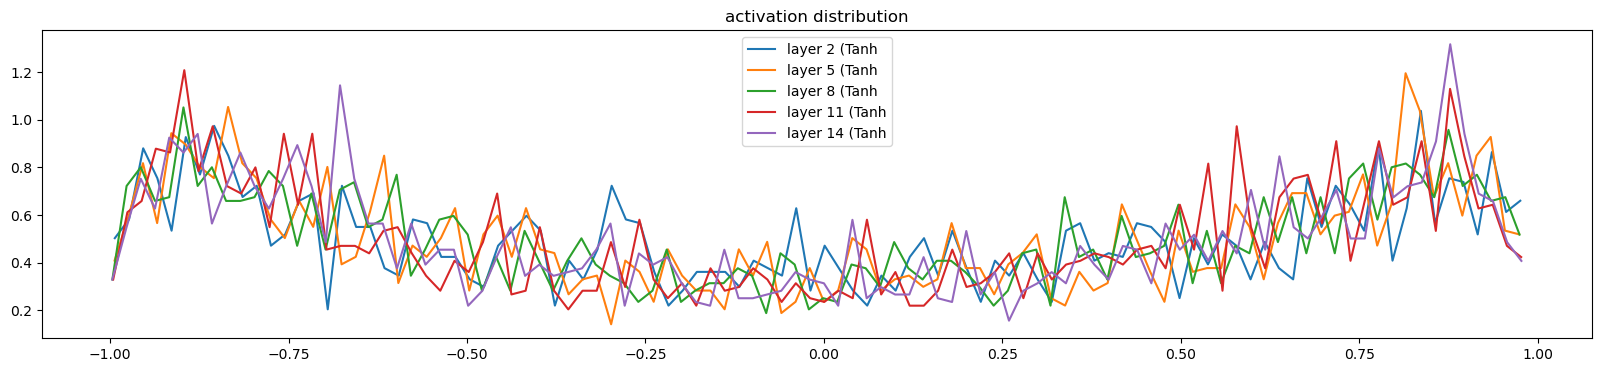

In [21]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.116050e-03
layer 5 (      Tanh): mean +0.000000, std 2.700654e-03
layer 8 (      Tanh): mean -0.000000, std 2.490950e-03
layer 11 (      Tanh): mean +0.000000, std 2.399036e-03
layer 14 (      Tanh): mean +0.000000, std 2.359055e-03


Text(0.5, 1.0, 'gradient distribution')

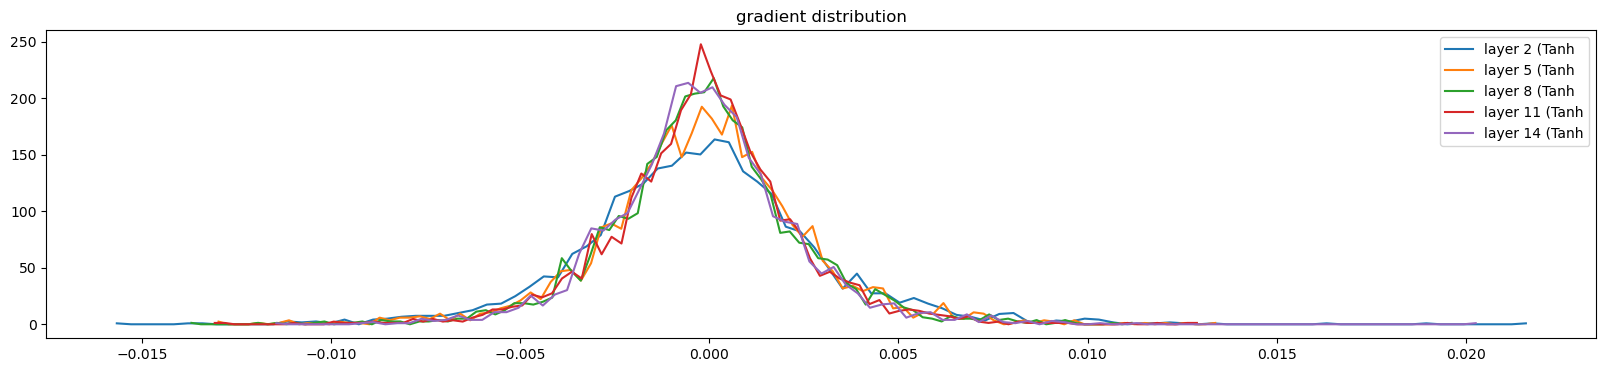

In [22]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 7.899689e-03 | grad:data ratio 7.891629e-03
weight  (30, 100) | mean -0.000112 | std 6.949332e-03 | grad:data ratio 2.223398e-02
weight (100, 100) | mean +0.000121 | std 5.596574e-03 | grad:data ratio 3.348061e-02
weight (100, 100) | mean +0.000079 | std 5.306156e-03 | grad:data ratio 3.146406e-02
weight (100, 100) | mean +0.000022 | std 5.094331e-03 | grad:data ratio 3.035058e-02
weight (100, 100) | mean -0.000001 | std 5.330182e-03 | grad:data ratio 3.174777e-02
weight  (100, 27) | mean -0.000141 | std 9.585499e-03 | grad:data ratio 5.749520e-02


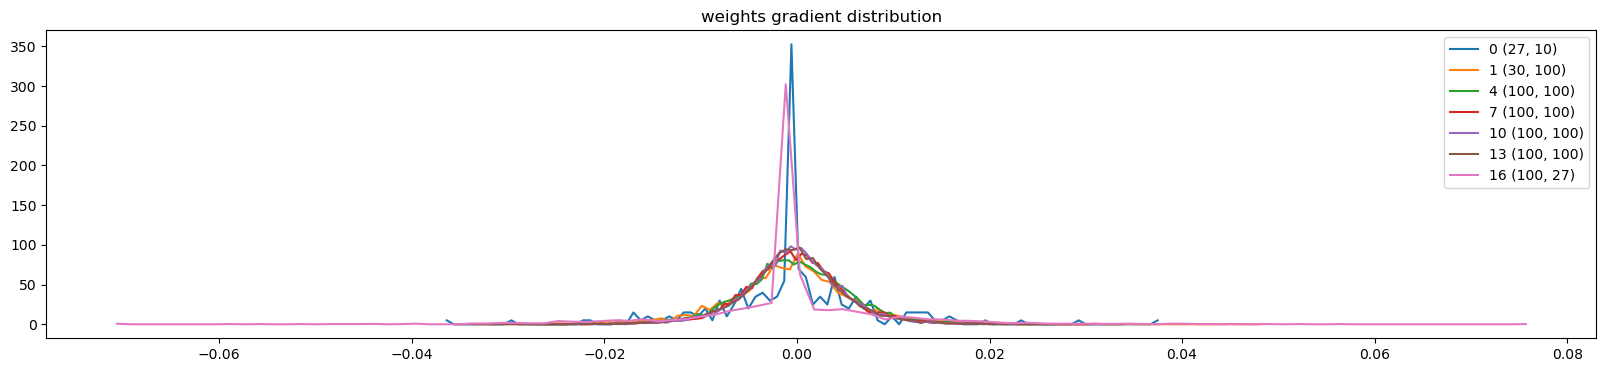

In [23]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

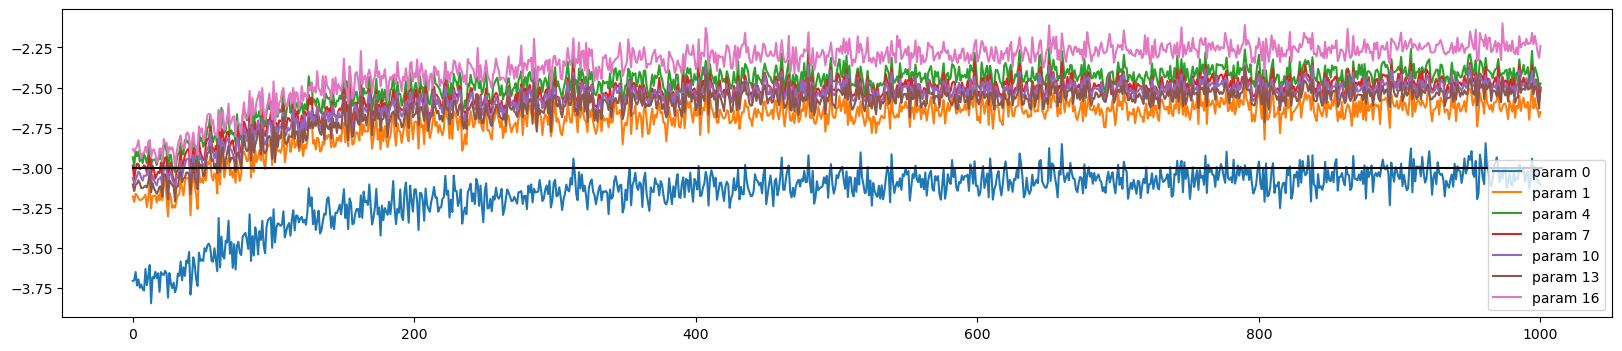

In [24]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [27]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.0108580589294434
val 2.0983986854553223


In [29]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(idx2char[i] for i in out)) # decode and print the generated word

flyra.
narta.
ambrira.
kathed.
dalan.
keobue.
noelle.
davynko.
scoshonadia.
katsifolny.
kacarlo.
jahvana.
davioluwatlee.
lea.
zory.
naya.
den.
kar.
rorrix.
kentruti.


In [31]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [32]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [34]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g)  / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  0.03164403513073921
x std:  0.9806987643241882
out std:  0.9999948143959045
------
out grad std:  0.9782556295394897
x grad std:  0.9975029230117798
w grad std:  0.9856600165367126
inp grad std:  0.9953002333641052
